In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances, pairwise_distances
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering

import libpysal
import spopt
import esda
import networkx as nx
import pygeoda

import matplotlib.pyplot as plt
import matplotlib as mpl
import contextily as ctx

import os

from src import algorithms, config, utils, plotting

# 1 Preparing dataset for clustering

In [2]:
features = pd.read_parquet(config.FEATURES_11)
tracts = gpd.read_parquet(config.TRACTS_CLEAN)

## 1.1 Temporarily remove small islands from the dataset

NYC has a few islands of 1-3 tracts that have people in them but aren't contiguous with the rest of the data. This will break some of the spatial clustering algorithms, so let's cut them from the main dataset and just consider each one its own cluster.

In [3]:
# -- Cut out islands --
min_cluster_size = 5
tracts, small_islands = utils.remove_small_islands(
    tracts, n_min=min_cluster_size
)
features_small_islands = [features.loc[island.index].copy() \
                          for island in small_islands]
features = features.loc[tracts.index]

We've identified four population "islands" that are not contiguous by land to any well-populated Census tracts. From left to right: City Island (The Bronx), Roosevelt Island (Manhattan), Breezy Point (Queens), and Broad Channel (Queens).

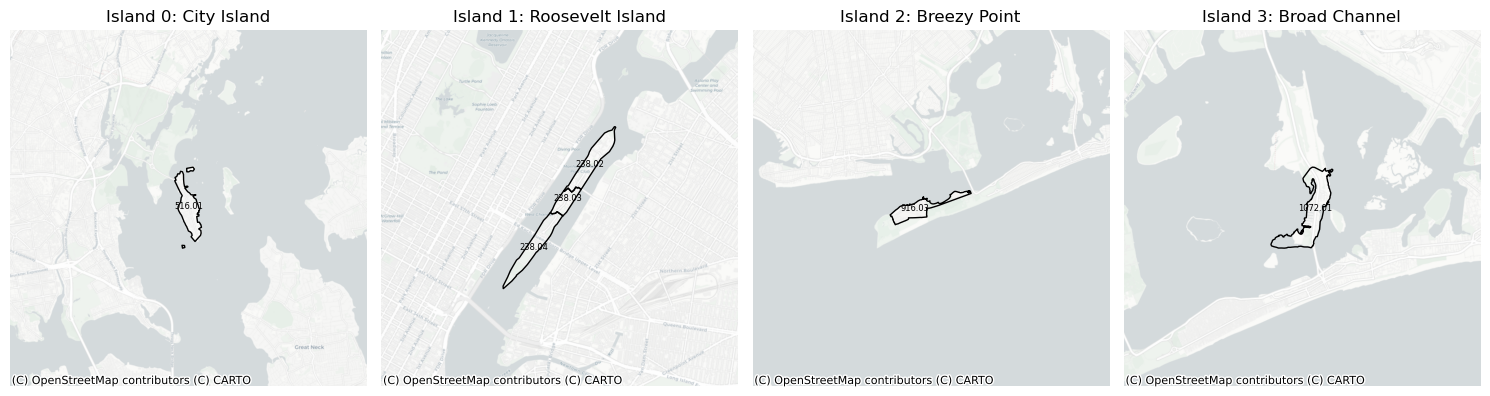

In [4]:
island_names = ["City Island", "Roosevelt Island", "Breezy Point", "Broad Channel"]

fig, ax = plt.subplots(1, 4, figsize=(15,5))
for i, island in enumerate(small_islands):
    __, __ = plotting.plot_tracts(island, figax=(fig, ax[i]))
    ax[i].set_title(f"Island {i}: {island_names[i]}")

The remaining 2206 Census tracts are split into five contiguous chunks: The Bronx, Manhattan, Queens/Brooklyn, Staten Island, and Rockaway Beach.

## 1.2 Standardize features

I want all of my features to be given equal weight in clustering, so I will standardize my features by z-score (rescaling and shifting to have a mean of 0 and standard deviation of 1).

In [5]:
# -- Standardize features --
feature_cols = features.columns
features_std = features.copy()
features_std[feature_cols] = StandardScaler().fit_transform(
    features_std[feature_cols]
)

# 2 Trying out different clustering algorithms

## 2.1 $k$-means clustering (`kmeans`)

To start, I want to cluster our dataset using $k$-means as a baseline. The benefits of this method are its speed, conceptual simplicity, and widespread use, making it a good initial attempt.

For this attempt, I will give the algorithm 10 clusters to work with. Ultimately, I will want many more, but this will provide a good diagnostic of how well the model performs.

In [16]:
# Define name of clustering model
alg = algorithms.kmeans
algorithm_name = "kmeans"
NC = 10
NF = len(features.columns)
model_name = f"f{NF}_{algorithm_name}_n{NC}"

# Set up clustering
nyc_demographics = tracts.join(features_std)
attrs = features_std.columns

# Solve
labels = alg(nyc_demographics, attrs, n=NC, seed=42)
labels.name = model_name

# Save labels
pd.DataFrame(labels).to_parquet(config.MODEL_DIR / f"{model_name}.parquet")

Text(0.5, 1.0, 'kmeans, 10 clusters')

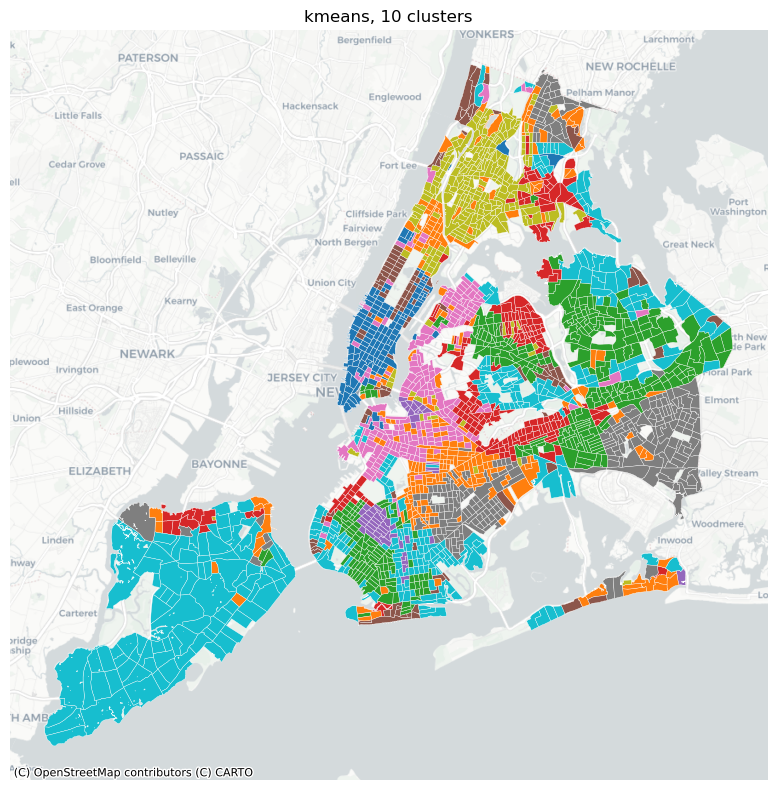

In [17]:
# Join with geometries
nyc_demographics = nyc_demographics.join(labels)

# Plot labels as categorical data
fig, ax = plotting.plot_categorical(nyc_demographics, model_name)
ax.set_title(f"{algorithm_name}, {NC} clusters")

Honestly, this is significantly better than I thought it would be. Already, we can see distinct regions emerge in different parts of the city! That said, it is clear that our clusters ignore spatial contiguity, in that demographically similar but geographically distant regions are clustered together:
- Staten Island is grouped with Middle Village and Forest Hills
- All three Chinatowns are grouped together (along with other immigrant communities like Jackson Heights)
- Many Hispanic-dominant areas like Corona (Queens), Sunset Park (Brooklyn), Woodhaven (Queens), and parts of the Bronx and Staten Island are all grouped together.
- Two heavily orthodox Jewish communities (Borough Park and South Williamsburg) are grouped together.

Additionally, some regions do not have well-defined geographical boundaries between clusters and instead feature tracts of multiple clusters interspersed, such as in South Brooklyn, Harlem, and Bed-Stuy. These represent demographic profiles on the boundary between two clusters over a geographically extended region.

Ultimately, I'd like a clustering algorithm that produces spatially contiguous and relatively compact clusters, while not ignoring demographic data. For that, we need spatial clustering algorithms.

## 2.2 Spatially constrained $k$-means (`sc-kmeans`)

A simple way to incorporate spatial information is to perform a normal clustering algorithm under the constraint of preserving spatial connectivity. The package `spopt` provides such a modification off of $k$-means with the model `spopt.region.RegionKMeansHeuristic()`, which I play with here.

A complication to spatial clustering with this model (and later ones as well) is that the solve breaks if not all tracts are fully connected. Even after removing the small isolated "island" tracts earlier, NYC still has 5 disconnected regions (The Bronx, Queens/Brooklyn, Manhattan, Rockaway Beach, and Staten Island). This means I actually need to run the model 5 times, one for each connected region. Most of these models require pre-specifying the number of clusters. To deal with this, I assign the clusters proportionally based on the number of tracts per connected region (see `utils.perform_multicomponent_cluster`).

In [18]:
# Define name of clustering model
alg = algorithms.sc_kmeans
algorithm_name = "sc-kmeans"
NC = 40
NF = len(features.columns)
model_name = f"f{NF}_{algorithm_name}_n{NC}"

# Set up clustering
nyc_demographics = tracts.join(features_std)
attrs = features_std.columns

# Perform clustering algorithm
labels = utils.perform_multicomponent_cluster(
                nyc_demographics, attrs,
                nc=NC,
                alg=alg,
                name=model_name,
                seed=42
)

# Save labels
pd.DataFrame(labels).to_parquet(config.MODEL_DIR / f"{model_name}.parquet")

Here are the resulting clusters, labeled 0-39:

Text(0.5, 1.0, 'sc-kmeans, 40 clusters')

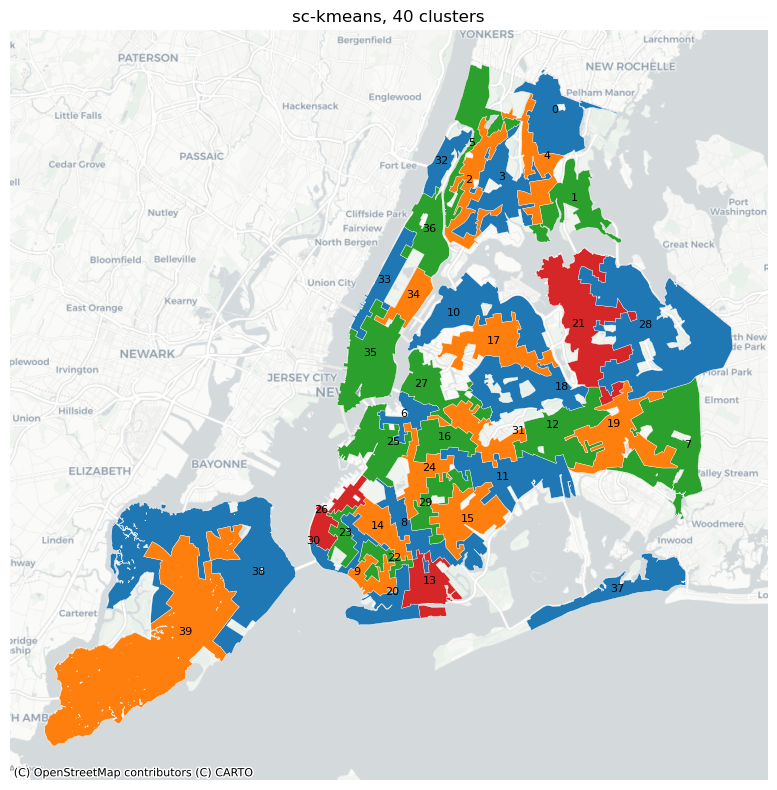

In [19]:
# Join with geometries
nyc_demographics = nyc_demographics.join(labels)

# Dissolve tracts into cluster regions and visualize
fig, ax = plotting.plot_clusters(nyc_demographics, model_name)
ax.set_title(f"{algorithm_name}, {NC} clusters")

This model at least produces contiguous regions, so we are closer to our goal. Still, a lot of these regions are snakey (e.g., cluster 2 in The Bronx and clusters 8 and 22 in south Brooklyn). Even with the spatial constraint, the algorithm still over-prioritizes compactness in feature space over that in geographical space. If it can find a path connecting two similar areas, no matter how snakey, it will do so.

## 2.3 Spatially constrained agglomerative clustering (`sc-agg`)

Unlike $k$-means, agglomerative clustering iteratively builds large clusters by merging smaller ones together. Combined with a spatial constraint of only merging contiguous clusters, this holds the potential to create more compact-looking clusters. Agglomerative clustering requires a "linkage" rule to determine which clusters to merge in any given step. I'll use a Ward linkage, which chooses merges that minimize the increase of within-cluster variances. Hopefully, this will create compact clusters both in feature space and geographically.

In [22]:
# Define name of clustering model
alg = algorithms.sc_agg
algorithm_name = "sc-agg"
NC = 60
NF = len(features.columns)
model_name = f"f{NF}_{algorithm_name}_n{NC}"

# Set up clustering
nyc_demographics = tracts.join(features_std)
attrs = features_std.columns

# Perform clustering algorithm
labels = utils.perform_multicomponent_cluster(
                nyc_demographics, attrs,
                nc=NC,
                alg=alg,
                name=model_name,
                seed=42 # not used for this model
)

# Save labels
pd.DataFrame(labels).to_parquet(config.MODEL_DIR / f"{model_name}.parquet")

Text(0.5, 1.0, 'sc-agg, 60 clusters')

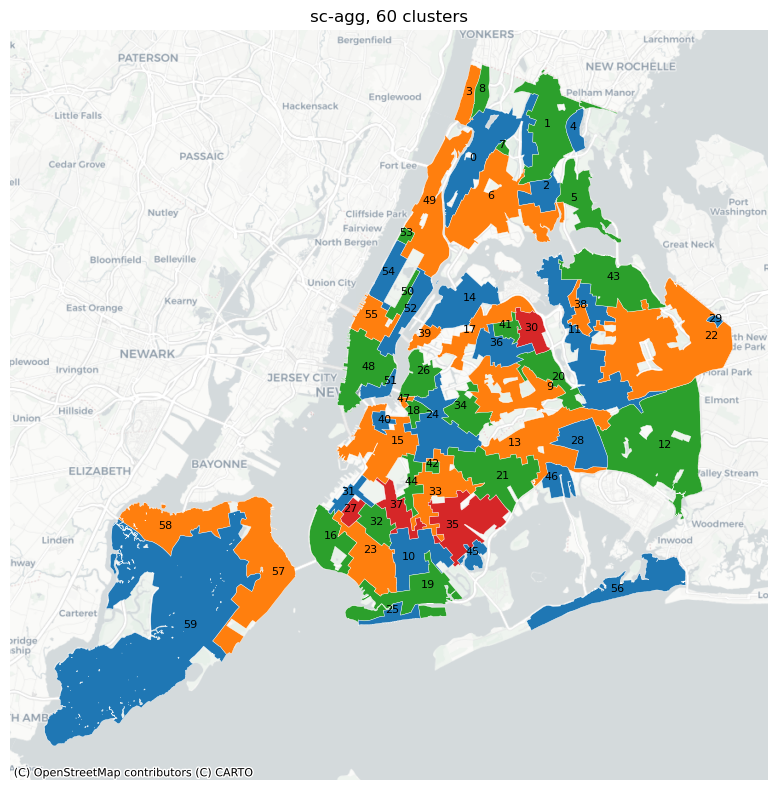

In [23]:
# Join with geometries
nyc_demographics = nyc_demographics.join(labels)

# Dissolve tracts into cluster regions and visualize
fig, ax = plotting.plot_clusters(nyc_demographics, model_name)
ax.set_title(f"{algorithm_name}, {NC} clusters")

Wow, these look a lot more realistic! Clusters are more compact and better align with prior expectations about NYC neighborhoods. There's a Flushing cluster (38), a Borough Park cluster (32), and a Harlem cluster (49), to name a few. This method seems to have some very small clusters (29, 42, 47) when using a larger cluster number like 60, for no apparent reason. It would be nice if I could implement a minimum cluster size.